In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.cyc_gbm import CycGBM, tune_kappa
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from src.distribution import Distribution

In [5]:
n = 1000
rng = np.random.default_rng(seed=10)
X0 = np.arange(0, n)
X1 = np.arange(0, n)
rng.shuffle(X1)
mu = np.exp(1 * (X0 > 0.3 * n) + 0.5 * (X1 > 0.5 * n))
phi = np.exp(1 + 1 * (X0 < 0.4 * n))

X = np.stack([X0, X1]).T
y = rng.gamma(1 / phi, mu * phi)

kappa_max = 1000
eps = 0.1
max_depth = 2
min_samples_leaf = 20
random_state = 5
n_splits = 4
kappa, loss = tune_kappa(
    X=X,
    y=y,
    kappa_max=kappa_max,
    eps=eps,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    dist="gamma",
    n_splits=n_splits,
    random_state=random_state,
)

print(kappa)

[10 27]


BOpt mu: 11
BOpt phi: 20


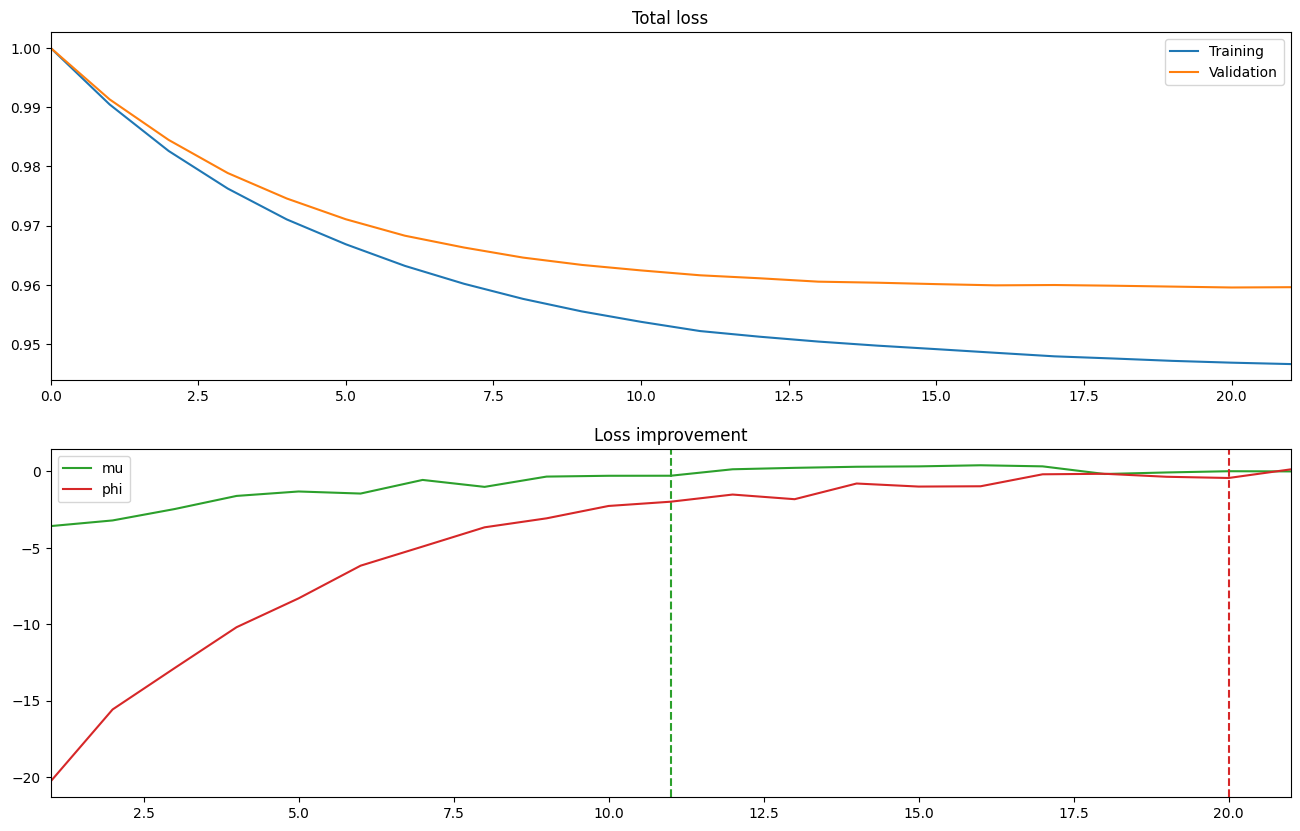

In [7]:
# Set hyperparameters
BMax = kappa_max
nFolds = n_splits
d = 2
epsilon = [eps] * d

from scipy.special import loggamma as lg
from scipy.special import polygamma as pg

# Loss function
def lossEval(z,y):
    loss = lg(np.exp(-z[1]))+np.exp(-z[1])*(y*np.exp(-z[0])-np.log(y)+z[0]+z[1])
    return loss

# Gradients
def grad0(z,y):
    grad = np.exp(-z[1])*(1-y*np.exp(-z[0]))
    return grad

def grad1(z,y):
    grad = np.exp(-z[1])*(1+np.log(y)-z[0]-z[1]-y*np.exp(-z[0])-pg(0,np.exp(-z[1])))
    return grad

# Gradient list
grads = [grad0,grad1]

# Optimal node value
def gammaOpt0(z,y,gamma0=0):
    gammaOpt = np.log((y*np.exp(-z[0])).sum())-np.log(len(y))
    return gammaOpt

def gammaOpt1(z,y,gamma0):
    to_min = lambda gamma: lossEval(z+e[1]*gamma,y).sum()
    gammaOpt = minimize(to_min,x0 = gamma0)['x'][0]
    return gammaOpt

gammaOpts = [gammaOpt0,gammaOpt1]

param_names = ['mu','phi']

kf = KFold(n_splits=nFolds, shuffle=True, random_state=random_state)

# Tree fitting
from sklearn.tree import DecisionTreeRegressor as regressionTree
def trainTree(z, y, x, grad, max_depth, min_samples_leaf):
    tree = regressionTree(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
    g = grad(z,y)
    tree.fit(x,-g)
    return tree

# Local tree training function
def trainThisTree(z, y, x, grad, max_depth = max_depth, min_samples_leaf = min_samples_leaf):
    return trainTree(z,y,x,grad,max_depth,min_samples_leaf)

# Evaluation arrays (indexed by fold, boosting step)
lossTrain, lossValid = np.zeros((nFolds,BMax,d)), np.zeros((nFolds,BMax,d))

# Dimension indicator for score adding
e = [np.stack([[0]]*j+[[1]] +[[0]]*(d-j-1)) for j in range(0,d)]

# Intercept model
xTrain, yTrain = X, y
nTrain = len(yTrain)

toMin = lambda z: lossEval(z,yTrain).sum()
zOpt = minimize(toMin,np.zeros(d))['x']

# Fit to all folds
for i, idx in enumerate(kf.split(X)):
    # Training and validation data
    idx_train, idx_valid = idx
    xTrain, yTrain = X[idx_train], y[idx_train]
    xValid, yValid = X[idx_valid], y[idx_valid]
    nTrain, nValid = len(yTrain), len(yValid)

    # Initiate score
    zTrain = zOpt.repeat(nTrain).reshape((d,nTrain))
    zValid = zOpt.repeat(nValid).reshape((d,nValid))

    # Initiate loss
    for j in range(0,d):
        lossTrain[i,0,j] = lossEval(zTrain, yTrain).sum()
        lossValid[i,0,j] = lossEval(zValid, yValid).sum()

    # Build trees
    for b in range(1,BMax):
        # For all parameter dimensions
        for j in range(0,d):
            # Fit a tree
            tree = trainThisTree(zTrain,yTrain,xTrain,grads[j])

            # Score updates
            zTrainPlus = tree.predict(xTrain)
            zValidPlus = tree.predict(xValid)

            # Look at all unique node values
            nodeValues = np.unique(zTrainPlus)
            for k,nodeValue in enumerate(nodeValues):
                # Indices with this node value
                indicesTrain = zTrainPlus==nodeValue
                indicesValid = zValidPlus==nodeValue
                # Optimize step size
                # Optimize step size
                gammaOpt = gammaOpts[j](zTrain[:,indicesTrain],
                                        yTrain[indicesTrain],
                                        nodeValue)
                # Manipulate node values
                zTrainPlus[indicesTrain] = gammaOpt
                zValidPlus[indicesValid] = gammaOpt

            # Update score
            zTrain[j] += epsilon[j]*zTrainPlus
            zValid[j] += epsilon[j]*zValidPlus

            # Update loss
            lossTrain[i,b,j] = lossEval(zTrain, yTrain).sum()
            lossValid[i,b,j] = lossEval(zValid, yValid).sum()

        # Check breaking criteria
        if lossValid[i,b,0]>lossValid[i,b-1,1] and lossValid[i,b,1]>lossValid[i,b,0]:
            lossTrain[i,b+1:,:] = lossTrain[i,b,-1]
            lossValid[i,b+1:,:] = lossValid[i,b,-1]
            break

# Sum the losses
lossTrainTot = lossTrain.sum(axis=0)[:,-1]
lossValidTot = lossValid.sum(axis=0)[:,-1]

# Calculate loss improvements
lossValidPerUpdate = lossValid.sum(axis=0)
lossImprovement = np.zeros((BMax,d))
lossImprovement[1:,0] = lossValidPerUpdate[1:,0]-lossValidPerUpdate[:-1,1]
lossImprovement[1:,1] = lossValidPerUpdate[1:,1]-lossValidPerUpdate[1:,0]

# Pick optimal number of boosters
BOpts = np.argmax(lossImprovement[1:]>0,axis=0)
BOpt = int(max(BOpts))
[print(f'BOpt {param_names[j]}: {int(BOpts[j])}') for j in range(0,d)]

# Visualize
fig, axs = plt.subplots(2,1,figsize=(16,16/1.61))

# Show validation losses
axs[0].plot(lossTrainTot[:BOpt+2]/np.abs(lossTrainTot[0]),label = 'Training');
axs[0].plot(lossValidTot[:BOpt+2]/np.abs(lossValidTot[0]),label = 'Validation');
axs[0].legend()
axs[0].set_title('Total loss')
axs[0].set_xlim([0,BOpt+1]);

# Show loss improvements
colors = ['tab:green','tab:red']
for j in range(0,d):
    axs[1].plot(np.arange(1,BOpt+3),lossImprovement[1:BOpt+3,j],
                label = param_names[j],
                color = colors[j]);
    axs[1].axvline(BOpts[j],linestyle='--',color=colors[j]);

axs[1].legend()
axs[1].set_title('Loss improvement')
axs[1].set_xlim([1,BOpt+1]);


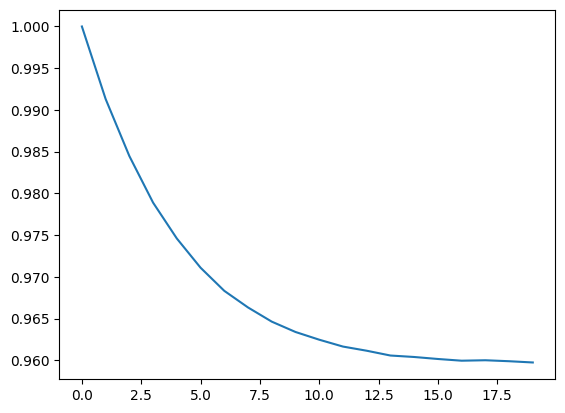

In [8]:
plt.plot(lossValidTot[:20]/lossValidTot[0])

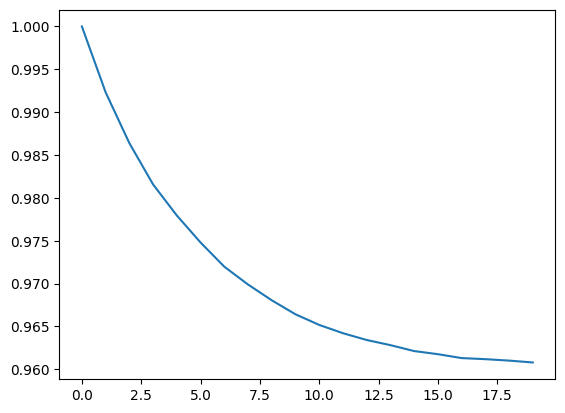

In [9]:
loss_total = loss.sum(axis=0)[:,-1]
plt.plot(loss_total[:20]/loss_total[0])
